In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.colors import LogNorm

In [7]:
Npix = 2**12
Npad = 2**8
Nfft = Npix*Npad

def freq2lam(freq_MHz):
    # Turns frequency into wavelength
    return 3e8/(freq_MHz*1e6)

def image2uv(image):
    # u and v are wavevectors (think of them as similar to ells decomposed into x and y)
    # uv plane is the FT of the image (the sky)
    assert(len(image)==Npix)
    bigimage = np.zeros(Npix*Npad)
    bigimage[:Npix//2] = image[-Npix//2:] # Put last half of image in beginning of bigimage
    bigimage[-Npix//2:] = image[:Npix//2] # Put first half of image at end of bigimage
    return rfft(bigimage)

def uv2image(uv):
    assert(len(uv) == Nfft//2+1)
    bigimage = irfft(uv)
    image = np.hstack((bigimage[-Npix//2:],bigimage[:Npix//2]))
    return image

def alpha():
    return (np.arange(-Npix//2,Npix//2)+0.5)*(2/Npix)

def DoL():
    # D/lambda
    return np.arange(Nfft//2+1)/Npad/2

def empty_uv():
    return np.zeros(Nfft//2+1,np.complex)

def empty_image():
    return np.zeros(Nfft,np.real)

def DoL2ndx(DoL):
    return int(DoL*Npad*2+0.5) # Nearest integer

def primary_beam_1(D,freq_MHz,diameter):
    # D in meters
    lam = freq2lam(freq_MHz)
    t = empty_uv()
    # Uniform beam (uniform sensitivity) up to maximum u (i.e. minimum separation); 0 past the diffraction limit
    # Small baseline length = can only see larger things in the sky
    #t[:DoL2ndx(D/lam/2)] = 1 # Choosing 1 means assuming the dishes are super large (it can see the whole sky)
    u_idx = np.linspace(0, 1, DoL2ndx(D/lam/2)) # Array of the non-zero t indices, normalized
    # Rather than uniform beam, we approximate the beam to be Gaussian; it should be dependent on u
    # Standard deviation is proportional to the FWHM, which is the beam width k*lambda/diameter; mean is zero
    # Try different multipliers to the sigma in the Gaussian
    t[:DoL2ndx(D/lam/2)] = np.exp(-(u_idx*diameter/(lam*30))**2)
    return uv2image(t)

Get beam sensitivity:

Text(0, 0.5, 'Power')

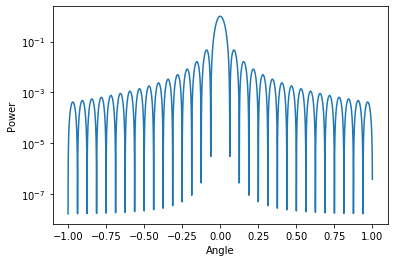

In [8]:
pbeam = primary_beam_1(6,800,1)**2 
plt.plot(alpha(),pbeam/pbeam.max())
plt.semilogy()
plt.xlabel('Angle')
plt.ylabel('Power')

Now let's plot some wedge.

In [9]:
Nfreq = 128
freqs = np.linspace(400,800,Nfreq)
Ndishes = 32
lams = freq2lam(freqs)
DDish = 6
# This is a 2D array of (Nfreq x Nbaselines) containing D/lambda for each
DoLams = np.outer(1/lams, DDish*np.arange(0,Ndishes))
# This is an array of indices in the uv plane that we are sensitive to, for each D/lambda
indices = (DoLams*Npad*2+0.5).astype(int)

Now we will just simulate various skies with point sources, which are flat in frequency, so only one FFT.
Then do the FFT along the frequency direction and hopefully we see the wedge.
We need to do this for many realizations of the sky to get statistics.

In [10]:
Nrel = 10 # Number of realizations
# Let's make dishes smaller to see horizon more clearly - hence the 1/5 below
diam = 1 # TODO: diameter?
p2fac = [np.abs(primary_beam_1(DDish,f,diam/5)**2)/np.cos(alpha()) for f in freqs] # Power divided by cos(alpha)
uvplane = np.zeros((Nfreq,Ndishes),np.complex)
ps = np.zeros((Nfreq+1,Ndishes)) # 2*Nfreq//2+1 = Nfreq+1
for c in range(Nrel):
    # Create a random sky, this sky will be the same at all frequencies
    sky = np.random.uniform(0,1,Npix)
    # Loop over frequencies
    for i,f in enumerate(freqs):
        # Multiply by the beam**2/cos to get the measured sky
        msky = sky * p2fac[i] # p2fac is how sensitive the antennas are to each point in the sky
        # FT to the uv plane and sample at indicies corresponding to D/lambda
        # We're only sensitive to certain us (determined by D/lambda, due to destructive interference) in uv plane
        uvplane[i,:] = image2uv(msky)[indices[i,:]]
    # After uv plane is done, calculate power spectrum ps in the frequency direction - this gives delay spectrum
    for j in range(Ndishes):
        # FFT along frequency axis, get the power in the frequency domain
        # Power in the frequency domain gives us structure in the redshift direction, for 21 cm
        ps[:,j] += np.abs(rfft(np.hstack((uvplane[:,j],np.zeros(Nfreq))))**2)

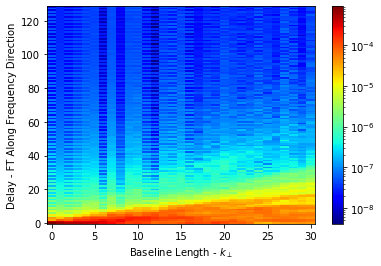

In [11]:
plt.imshow(ps[:,1:],origin='lower',aspect='auto',interpolation='nearest', norm=LogNorm(), cmap='jet')
plt.xlabel(r'Baseline Length - $k_\perp$')
plt.ylabel('Delay - FT Along Frequency Direction')
plt.colorbar()